# 3.3 Validation
Information derived from satellite observation is useless without stating it's accuracy. 
This exercise will show you how to validate results obtained on a cloud platforms. 
- Load inference datasets,
- Load ground-truth(in-situ) datasets,
- Select ROI and stations location datasets, 
- Extract point values from station, 
- Perform verification -- binary classification (true or false matching)
- Compute metrics and decide on the usefulness of the inference datasets

In [1]:
import openeo
import numpy as np 
import xarray as xr
import rioxarray as rio 

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

import pandas as pd
import geopandas as gpd
import folium
from sentinelhub import (SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, BBox, bbox_to_dimensions, geometry)

In [2]:
config = SHConfig()
config.sh_client_id = %env SH_CLIENT_ID
config.sh_client_secret = %env SH_CLIENT_SECRET

In [3]:
conn = openeo.connect('https://jjdxlu8vwl.execute-api.eu-central-1.amazonaws.com/production')

In [4]:
conn.authenticate_basic(username=config.sh_client_id, password=config.sh_client_secret)

<Connection to 'https://jjdxlu8vwl.execute-api.eu-central-1.amazonaws.com/production/' with BasicBearerAuth>

In [34]:
# Use this for more 
# https://github.com/openEOPlatform/sample-notebooks/blob/main/openEO%20Platfrom%20-%20Basics.ipynb
# https://github.com/Open-EO/openeo-community-examples/tree/main/python

In [5]:
# load NDSI in Zarr format
# NOTE: awaiting Sinergise backend to update the creation of ZARR files

In [6]:
# load catchment area
catchment_outline = gpd.read_file('data/catchment_outline.geojson')
# catchment_outline_json = catchment_outline.to_json()
# bbox = catchment_outline.bounds.iloc[0]
# catchment_outline.geometry

In [9]:
# load snow station datasets from zenodo:: https://zenodo.org/record/5109574
station_df = pd.read_csv("data/data_daily_IT_BZ.csv")
station_df.head()

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill
0,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-01,NaN,NaN,NaN,NaN,19.0
1,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-02,NaN,NaN,NaN,NaN,18.0
2,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-03,NaN,NaN,NaN,NaN,18.0
3,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-04,NaN,NaN,NaN,NaN,18.0
4,IT_BZ,Alliz_Maso_Strimo_Osservatore,1996-01-05,NaN,NaN,NaN,NaN,17.0


In [10]:
station_df_meta = pd.read_csv("data/meta_all.csv")
station_df_meta.head()

,Provider,Name,Longitude,Latitude,Elevation,HN_year_start,HN_year_end,HS_year_start,HS_year_end
0,AT_HZB,Absdorf,15.976667,48.401667,182.0,1970.0,2016.0,1970.0,2016.0
1,AT_HZB,Ach_Burghausen,12.846389,48.148889,473.0,1990.0,2016.0,1990.0,2016.0
2,AT_HZB,Admont,14.457222,47.567778,700.0,1970.0,2016.0,1970.0,2016.0
3,AT_HZB,Afritz,13.795556,46.727500,715.0,1970.0,2016.0,1970.0,2016.0
4,AT_HZB,Alberschwende,9.849167,47.458333,717.0,1982.0,2016.0,1982.0,2016.0


In [28]:
full_station = pd.merge(station_df,
                        station_df_meta,
                        how="inner",
                        on=["Provider", "Name"])
full_station = full_station.drop(["HN_year_start", "HN_year_end", "HS_year_start", "HS_year_end"], axis=1)
full_station = full_station.reset_index(drop=True)
full_station.sample(10)

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation
644034,IT_BZ,S_Vito_di_Braies_Osservatore,2005-04-13,NaN,NaN,NaN,NaN,NaN,12.100020,46.711878,1285.0
537327,IT_BZ,S_Cassiano_Osservatore,1995-02-19,NaN,40.0,NaN,40.0,40.0,11.936462,46.568713,1545.0
646590,IT_BZ,S_Vito_di_Braies_Osservatore,2012-04-12,4.0,NaN,4.0,NaN,3.0,12.100020,46.711878,1285.0
86226,IT_BZ,Costalovara_Osservatore,2014-01-28,12.0,NaN,12.0,NaN,NaN,11.429301,46.527489,1250.0
383155,IT_BZ,Monte_Maria_Osservatore,1982-01-10,0.0,45.0,0.0,45.0,45.0,10.520996,46.706251,1335.0
143583,IT_BZ,Diga_di_Vizze_Osservatore,2000-02-10,3.0,12.0,3.0,12.0,12.0,11.524672,46.924992,1365.0
778493,IT_BZ,Vanga_Osservatore,2011-06-02,0.0,0.0,0.0,0.0,0.0,11.397473,46.551795,920.0
684986,IT_BZ,Sesto_Osservatore,2000-05-29,0.0,0.0,0.0,0.0,0.0,12.349964,46.703053,1310.0
26844,IT_BZ,Anterselva_di_Mezzo_Osservatore,2000-06-29,0.0,0.0,0.0,0.0,0.0,12.100897,46.860722,1236.0
336357,IT_BZ,Mazia_Osservatore,2004-11-24,NaN,0.0,NaN,0.0,0.0,10.617526,46.694316,1570.0


In [29]:
# convert lat long to geometries
snow_stations = gpd.GeoDataFrame(
    full_station,
    geometry=gpd.points_from_xy(full_station.Longitude, full_station.Latitude),
    crs="EPSG:4326"
)
snow_stations.sample(10)
# snow_stations.head()

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry
248349,IT_BZ,La_Villa_in_Badia_Osservatore,1995-12-11,0.0,7.0,0.0,7.0,7.0,11.907076,46.583630,1390.0,POINT (11.90708 46.58363)
69139,IT_BZ,Casere_di_Fuori_Osservatore,2015-04-17,0.0,0.0,0.0,0.0,0.0,10.926697,46.735100,1705.0,POINT (10.92670 46.73510)
738690,IT_BZ,Terme_di_Brennero_Osservatore,2011-06-11,0.0,0.0,0.0,0.0,0.0,11.488931,46.981130,1330.0,POINT (11.48893 46.98113)
74301,IT_BZ,Corona_Cortaccia_Osservatore,2011-06-05,0.0,0.0,0.0,0.0,0.0,11.206752,46.320754,890.0,POINT (11.20675 46.32075)
331662,IT_BZ,Mazia_Osservatore,1992-01-17,NaN,24.0,NaN,24.0,24.0,10.617526,46.694316,1570.0,POINT (10.61753 46.69432)
288402,IT_BZ,Longiaru_Osservatore,1988-08-08,0.0,0.0,0.0,0.0,0.0,11.860878,46.639345,1396.0,POINT (11.86088 46.63934)
707652,IT_BZ,Slingia_Osservatore,1992-06-18,NaN,0.0,NaN,0.0,0.0,10.473920,46.704131,1690.0,POINT (10.47392 46.70413)
601124,IT_BZ,S_Martino_in_Passiria_Osservatore,2017-10-20,0.0,0.0,0.0,0.0,0.0,11.227909,46.782682,588.0,POINT (11.22791 46.78268)
759906,IT_BZ,Valluzza_Osservatore,1997-07-12,NaN,0.0,NaN,0.0,0.0,11.662810,46.623574,1350.0,POINT (11.66281 46.62357)
354665,IT_BZ,Meltina_Osservatore,1984-01-10,0.0,0.0,0.0,0.0,0.0,11.251688,46.585772,1133.0,POINT (11.25169 46.58577)


In [33]:
# select stations within catchment area
catchment_stations = gpd.sjoin(snow_stations, catchment_outline, op='within')
catchment_stations.head()

/home/conda/users/52c397debe78d7686aa36bd394f6f113e95009637029c5b71995fe48a567dcd4-20230418-061740-771350-145-edc-2023.03-02/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,...,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT
449985,IT_BZ,Plata_Osservatore,1980-01-01,NaN,NaN,NaN,NaN,26.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
449986,IT_BZ,Plata_Osservatore,1980-01-02,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
449987,IT_BZ,Plata_Osservatore,1980-01-03,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
449988,IT_BZ,Plata_Osservatore,1980-01-04,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988
449989,IT_BZ,Plata_Osservatore,1980-01-05,NaN,NaN,NaN,NaN,27.0,11.176968,46.822847,...,2090012980,334.5,334.5,419.1,419.2,214040804,0,0,3,10988


In [41]:
station_columns = ['Provider', 'Name', 'Date', 'HN', 'HS', 'HN_after_qc', 'HS_after_qc',
       'HS_after_gapfill', 'Longitude', 'Latitude', 'Elevation', 'geometry']

catchment_stations = catchment_stations[station_columns]
catchment_stations

,Provider,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Longitude,Latitude,Elevation,geometry
449985,IT_BZ,Plata_Osservatore,1980-01-01,NaN,NaN,NaN,NaN,26.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
449986,IT_BZ,Plata_Osservatore,1980-01-02,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
449987,IT_BZ,Plata_Osservatore,1980-01-03,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
449988,IT_BZ,Plata_Osservatore,1980-01-04,NaN,NaN,NaN,NaN,25.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
449989,IT_BZ,Plata_Osservatore,1980-01-05,NaN,NaN,NaN,NaN,27.0,11.176968,46.822847,1130.0,POINT (11.17697 46.82285)
...,...,...,...,...,...,...,...,...,...,...,...,...
677527,IT_BZ,Scena_Osservatore,2019-12-27,NaN,NaN,NaN,NaN,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)
677528,IT_BZ,Scena_Osservatore,2019-12-28,NaN,NaN,NaN,NaN,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)
677529,IT_BZ,Scena_Osservatore,2019-12-29,NaN,NaN,NaN,NaN,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)
677530,IT_BZ,Scena_Osservatore,2019-12-30,NaN,NaN,NaN,NaN,0.0,11.190831,46.689596,680.0,POINT (11.19083 46.68960)


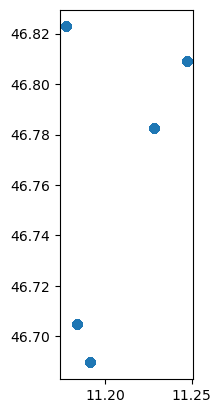

In [39]:
catchment_stations.plot()
catchment_stations.to_file("data/catchment_stations.geojson", driver="GeoJSON")

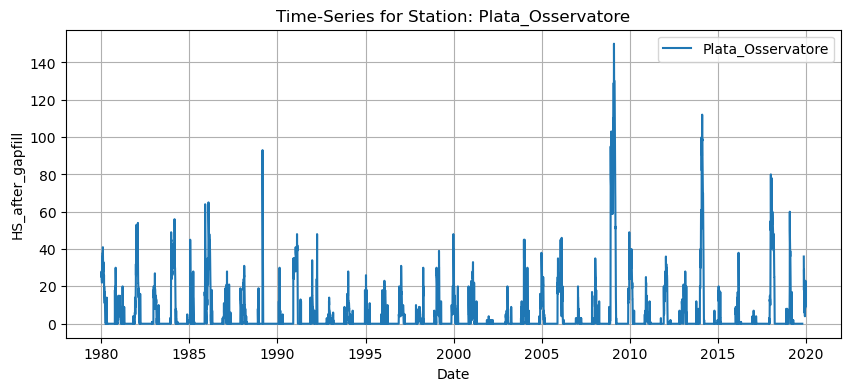

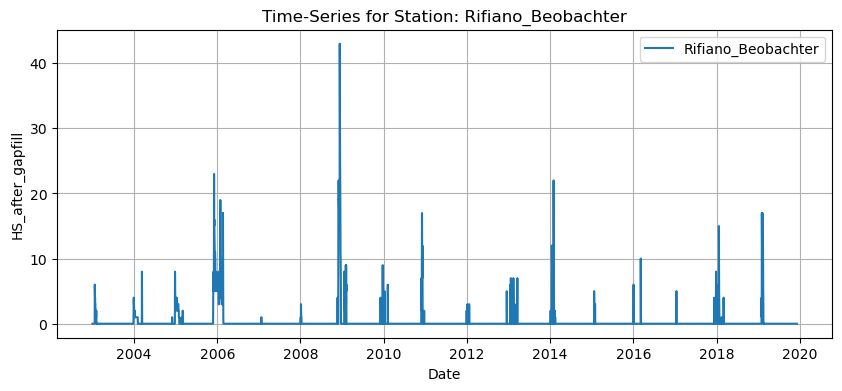

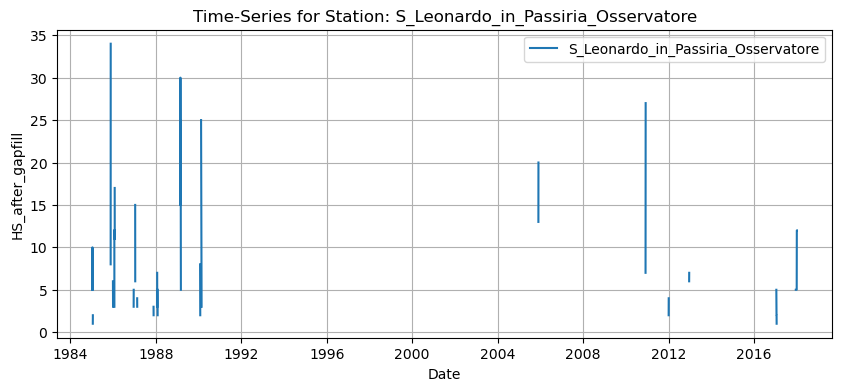

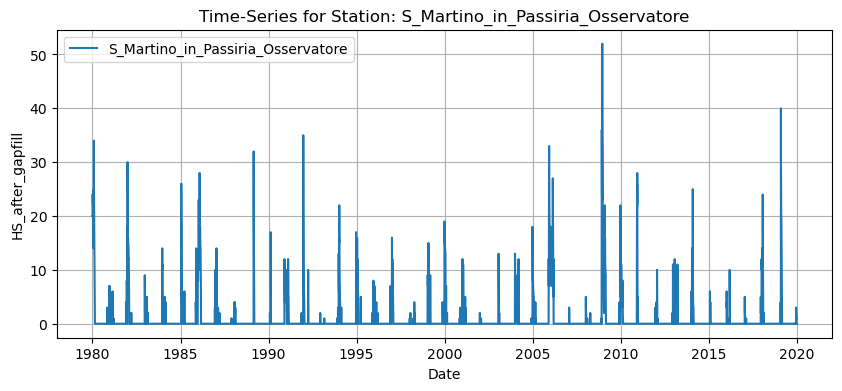

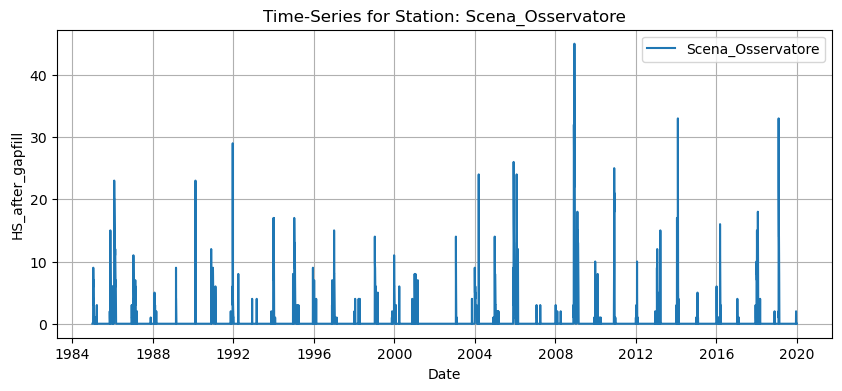

In [43]:
## TODO: show time-series of the stations
# Convert 'Date' to datetime format
catchment_stations['Date'] = pd.to_datetime(catchment_stations['Date'])

# Set 'Date' as the index
catchment_stations.set_index('Date', inplace=True)

# Get unique stations
unique_stations = catchment_stations['Name'].unique()

# Plot time-series for each station
for station in unique_stations:
    station_data = catchment_stations[catchment_stations['Name'] == station]
    plt.figure(figsize=(10, 4))
    plt.plot(station_data.index, station_data['HS_after_gapfill'], label=station)
    plt.title(f'Time-Series for Station: {station}')
    plt.xlabel('Date')
    plt.ylabel('HS_after_gapfill')
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
# load snow coverage grid
snow_grid = rio.open_rasterio("data/ndsi_max.tiff")
display(snow_grid.values)

array([[[0.79285175, 0.7994133 , 0.67720574, ..., 0.7761289 ,
         0.8108759 , 0.7856322 ],
        [0.83390886, 0.80718714, 0.80127716, ..., 0.79293495,
         0.82258064, 0.816163  ],
        [0.59643674, 0.6184211 , 0.6578765 , ..., 0.79516613,
         0.81645715, 0.803979  ],
        ...,
        [0.9234389 , 0.90247583, 0.902082  , ..., 0.7529947 ,
         0.79373753, 0.79000354],
        [0.92231256, 0.9010078 , 0.9001929 , ..., 0.77136844,
         0.81366557, 0.8009042 ],
        [0.91590047, 0.9083644 , 0.9098887 , ..., 0.796982  ,
         0.8237064 , 0.80756915]]], dtype=float32)

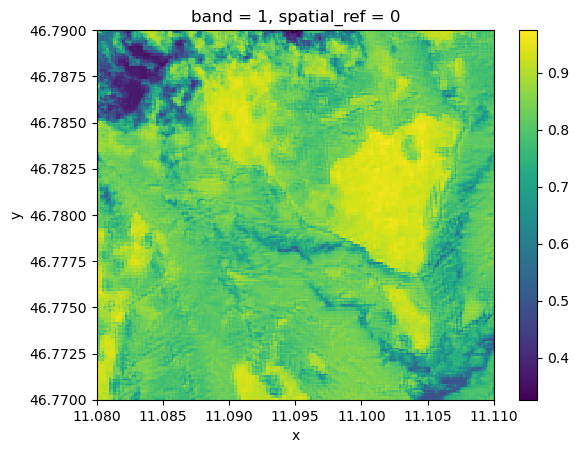

In [42]:
snow_grid.plot()

<Axes: >

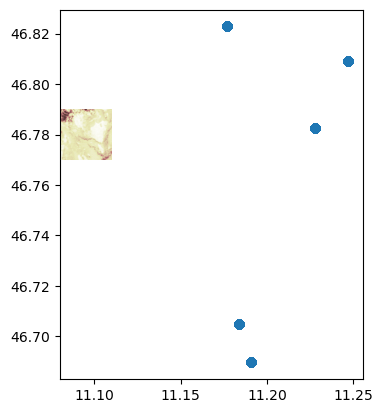

In [45]:
# display points and grid simultaneously
snow_grid_tif = rasterio.open("data/ndsi_max.tiff")
fig, ax = plt.subplots()
# transform rasterio plot to real world coords
extent = [snow_grid_tif.bounds[0], snow_grid_tif.bounds[2], snow_grid_tif.bounds[1], snow_grid_tif.bounds[3]]
ax = rasterio.plot.show(snow_grid_tif, ax=ax, cmap="pink")
within_catchment.plot(ax=ax)

In [46]:
# extract values from points
snow_grid_tif = rasterio.open("data/ndsi_max.tiff")
coord_list = [(x, y) for x, y in zip(snow_stations["Longitude"], within_catchment["Latitude"])]
within_catchment["value"] = [x for x in snow_grid_tif.sample(coord_list)]
within_catchment.sample(10)

,Provider_x,Name,Date,HN,HS,HN_after_qc,HS_after_qc,HS_after_gapfill,Provider_y,Longitude,...,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,value
514162,IT_BZ,Rifiano_Beobachter,2010-09-17,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.183607,...,334.5,334.5,419.1,419.2,214040804,0,0,3,10988,[0.0]
460062,IT_BZ,Plata_Osservatore,2007-08-04,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.176968,...,334.5,334.5,419.1,419.2,214040804,0,0,3,10988,[0.0]
592514,IT_BZ,S_Martino_in_Passiria_Osservatore,1994-03-25,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.227909,...,334.5,334.5,419.1,419.2,214040804,0,0,3,10988,[0.0]
599650,IT_BZ,S_Martino_in_Passiria_Osservatore,2013-10-07,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.227909,...,334.5,334.5,419.1,419.2,214040804,0,0,3,10988,[0.0]
594807,IT_BZ,S_Martino_in_Passiria_Osservatore,2000-07-04,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.227909,...,334.5,334.5,419.1,419.2,214040804,0,0,3,10988,[0.0]
598010,IT_BZ,S_Martino_in_Passiria_Osservatore,2009-04-11,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.227909,...,334.5,334.5,419.1,419.2,214040804,0,0,3,10988,[0.0]
588202,IT_BZ,S_Martino_in_Passiria_Osservatore,1982-06-04,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.227909,...,334.5,334.5,419.1,419.2,214040804,0,0,3,10988,[0.0]
673703,IT_BZ,Scena_Osservatore,2009-07-08,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.190831,...,334.5,334.5,419.1,419.2,214040804,0,0,3,10988,[0.0]
589611,IT_BZ,S_Martino_in_Passiria_Osservatore,1986-04-13,0.0,0.0,0.0,0.0,0.0,IT_BZ,11.227909,...,334.5,334.5,419.1,419.2,214040804,0,0,3,10988,[0.0]
451840,IT_BZ,Plata_Osservatore,1985-01-29,0.0,24.0,0.0,24.0,24.0,IT_BZ,11.176968,...,334.5,334.5,419.1,419.2,214040804,0,0,3,10988,[0.0]


In [51]:
len(np.unique(within_catchment.Date))/365

40.02739726027397

In [ ]:
# set threshold for snow values
# Reference: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndsi/#:~:text=The%20Sentinel%2D2%20normalized%20difference,above%200.42%20are%20usually%20snow.
# values above 0.42 are snow

# snow_grid.values
# np.unique(np.where(snow_grid.values > 0.42, 1, 0), return_counts=True) # i.e. 0 represent not snow and 1 represents snow. 

In [ ]:
# select ROI
# 'https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/exercises/data/catchment_outline.geojson'
# catchment_outline = gpd.read_file('data/catchment_outline.geojson')
# m = folium.Map(location=[catchment_outline.centroid.y, catchment_outline.centroid.x])
# folium.GeoJson(data=catchment_outline.to_json(), name='catchment').add_to(m)
# m

In [23]:
# data validation
snow_stations.to_csv("station_gdf.csv")
